In [1]:
import pandas as pd
import numpy as np
import torch
import torch.utils.data
import torch.nn as nn
from torch.autograd import Variable
import joblib
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
torch.cuda.is_available()

True

In [3]:
from isaac.dataset import read_dataset, prepare_dataset, sample_subsequences, split_in_subsequences
from isaac.models import ComplexRNNModel, initialise_model
from isaac.constants import *
from isaac.training import evaluate, training_loop, evaluate_saved_model
from isaac.sanity import class_proportions

In [4]:
BATCH_SIZE = 64
EPOCHS = 50
NORMALISE_DATA = True
STEP_SIZE = 2
SEQ_END = 1800

In [5]:
TR_COLS = ALT_BASIC_TRAINING_COLS + MOUSE_CONTROL_COLS + MOUSE_POSITION_COLS

In [8]:
len(MOUSE_CONTROL_COLS + MOUSE_POSITION_COLS)

7

In [9]:
len(TR_COLS)

23

# Define common model, loss and optimizer

In [10]:
INPUT_DIM = len(TR_COLS)    # input dimension
HIDDEN_DIM = 25  # hidden layer dimension
N_LAYERS = 4     # number of hidden layers
OUTPUT_DIM = 3   # output dimension
DROPOUT = 0.5

network_dims = (INPUT_DIM, HIDDEN_DIM, N_LAYERS, OUTPUT_DIM)

In [11]:
exp1_trials = read_dataset("data/yoked_trials_exp1.h5")
exp2_mass_trials = read_dataset("data/mass_trials_exp2.h5")
exp2_force_trials = read_dataset("data/force_trials_exp2.h5")

first_half = [trial[:1801] for trial in exp1_trials]
# second_half = [trial[-1801:] for trial in exp1_trials]

100%|██████████| 399/399 [00:06<00:00, 61.12it/s]


In [12]:
yoked_trials = first_half + exp2_mass_trials + exp2_force_trials

In [13]:
for trial in tqdm(yoked_trials):
    trial.mouseX = trial.mouseX * (trial.idControlledObject != "none").astype(int)
    trial.mouseY = trial.mouseY * (trial.idControlledObject != "none").astype(int)
    trial["mouse.vx"] *= (trial.idControlledObject != "none").astype(int)
    trial["mouse.vy"] *= (trial.idControlledObject != "none").astype(int)
    trial["mouse.speed"] *= (trial.idControlledObject != "none").astype(int)
    trial["mouse.angle"] *= (trial.idControlledObject != "none").astype(int)

  0%|          | 0/941 [00:00<?, ?it/s]/home/hector/miniconda3/envs/diss/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/home/hector/miniconda3/envs/diss/lib/python3.5/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/hector/miniconda3/envs/diss/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

In [14]:
np.random.seed(0)
indices = np.arange(len(yoked_trials))
test_indices = np.random.choice(indices, 150, replace=False)
val_indices = np.random.choice(list(set(indices) - set(test_indices)), 150, replace=False)
train_indices = list(set(indices) - set(test_indices) - set(val_indices))

train_trials = [yoked_trials[i] for i in train_indices]
val_trials = [yoked_trials[i] for i in val_indices]
test_trials = [yoked_trials[i] for i in test_indices]

passive_trials = read_dataset("data/train_passive_trials.h5", n_trials=len(train_trials) // 2)
passive_trials = [trial[:1801] for trial in passive_trials]

train_trials += passive_trials

In [15]:
len(train_trials), len(val_trials), len(test_trials)

(641, 150, 150)

# FORCE TRAINING  (Humans achieve 63% +- 21%)

## Read dataset and preprocess it

In [17]:
scaler_path = "scalers/passive_force_scaler.sk"
scaler = joblib.load(scaler_path)


import warnings
warnings.filterwarnings('ignore')
for dataset in [train_trials, val_trials, test_trials]:
    for i, trial in enumerate(tqdm(dataset)):
        dataset[i][BASIC_TRAINING_COLS] = scaler.transform(trial[BASIC_TRAINING_COLS])

In [18]:
loaders, scaler = prepare_dataset([train_trials, val_trials, test_trials], class_columns=FORCE_CLASS_COLS, 
                                  training_columns=TR_COLS,
                                  batch_size=BATCH_SIZE, normalise_data=NORMALISE_DATA, 
                                  categorical_columns=MOUSE_CONTROL_COLS, normalisation_cols=ALT_BASIC_TRAINING_COLS)

100%|██████████| 150/150 [00:00<00:00, 342.10it/s]


In [19]:
train_loader, val_loader, test_loader = loaders

In [20]:
class_proportions(train_loader)
print()
class_proportions(val_loader)
print()
class_proportions(test_loader)

[207 247 187]
Majority class:  0.38533541341653665

[58 52 40]
Majority class:  0.38666666666666666

[53 46 51]
Majority class:  0.35333333333333333


## Define model, loss and optimizer

model_path = "models/passive_force_model.pt"
model = ComplexRNNModel(*network_dims, DROPOUT)
model.load_state_dict(torch.load(model_path))
model = model.cuda()
model.rec_layer.requires_grad = True

error = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
model.train()

In [28]:
network_dims = (len(ALT_BASIC_TRAINING_COLS), HIDDEN_DIM, N_LAYERS, OUTPUT_DIM)
model_path = "models/passive_force_model.pt"
pretrained_model = ComplexRNNModel(*network_dims, DROPOUT)
pretrained_model.load_state_dict(torch.load(model_path))

class DualRNNModel(nn.Module):
    def __init__(self, dropout=0.):
        super(DualRNNModel, self).__init__()
        # RNN
        self.rec_layer = pretrained_model.rec_layer
        # self.gru_one = nn.GRU(9, 4, 2, batch_first=True, dropout=dropout)
        
        self.gru = nn.GRU(25 + 7, 15, 2, batch_first=True, dropout=dropout)
        # Readout layer
        self.fc = nn.Linear(15, 3)
    
    def forward(self, x):
        obj = x[:, : , :-7]
        mouse = x[:, :, -7:]
        
        out, _ = self.rec_layer(obj)
        # mouse, _ = self.gru_one(mouse)
        
        out = torch.cat((out, mouse), dim=2)
        out, _ = self.gru(out)
        
        out = self.fc(out[:, -1, :]) 
        return out

In [29]:
dual = DualRNNModel(DROPOUT)
error = nn.CrossEntropyLoss().cuda()
dual.rec_layer.requires_grad = False

optimizer = torch.optim.Adam(dual.parameters(), lr=0.0001)

dual = dual.cuda()

In [30]:
dual.train()

DualRNNModel(
  (rec_layer): GRU(16, 25, num_layers=4, batch_first=True, dropout=0.5)
  (gru): GRU(32, 15, num_layers=2, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=15, out_features=3, bias=True)
)

## Train model and plot loss and accuracy

In [42]:
epoch_losses, epoch_accuracies, best_model = training_loop(dual, optimizer, error, train_loader, val_loader,                                                           
                                                           EPOCHS, seq_end=SEQ_END, step_size=STEP_SIZE)


  0%|          | 0/50 [00:00<?, ?it/s]
Train_loss (-1.00)	 Train_acc (54.76)	 Val_acc (54.00):   0%|          | 0/50 [00:00<?, ?it/s]
Train_loss (-1.00)	 Train_acc (54.76)	 Val_acc (54.00):   2%|▏         | 1/50 [00:05<04:09,  5.10s/it]
Train_loss (0.88)	 Train_acc (55.07)	 Val_acc (54.67):   2%|▏         | 1/50 [00:05<04:09,  5.10s/it] 
Train_loss (0.88)	 Train_acc (55.07)	 Val_acc (54.67):   4%|▍         | 2/50 [00:10<04:04,  5.09s/it]
Train_loss (0.88)	 Train_acc (54.76)	 Val_acc (54.00):   4%|▍         | 2/50 [00:10<04:04,  5.09s/it]
Train_loss (0.88)	 Train_acc (54.76)	 Val_acc (54.00):   6%|▌         | 3/50 [00:15<03:59,  5.09s/it]
Train_loss (0.88)	 Train_acc (54.76)	 Val_acc (53.33):   6%|▌         | 3/50 [00:16<03:59,  5.09s/it]
Train_loss (0.88)	 Train_acc (54.76)	 Val_acc (53.33):   8%|▊         | 4/50 [00:20<03:53,  5.08s/it]
Train_loss (0.88)	 Train_acc (55.38)	 Val_acc (54.00):   8%|▊         | 4/50 [00:21<03:53,  5.08s/it]
Train_loss (0.88)	 Train_acc (55.38)	 Val_acc (

Train_loss (0.83)	 Train_acc (59.13)	 Val_acc (55.33):  78%|███████▊  | 39/50 [03:20<00:56,  5.10s/it]
Train_loss (0.83)	 Train_acc (58.97)	 Val_acc (55.33):  78%|███████▊  | 39/50 [03:20<00:56,  5.10s/it]
Train_loss (0.83)	 Train_acc (58.97)	 Val_acc (55.33):  80%|████████  | 40/50 [03:25<00:51,  5.12s/it]
Train_loss (0.84)	 Train_acc (58.97)	 Val_acc (55.33):  80%|████████  | 40/50 [03:26<00:51,  5.12s/it]
Train_loss (0.84)	 Train_acc (58.97)	 Val_acc (55.33):  82%|████████▏ | 41/50 [03:30<00:46,  5.13s/it]
Train_loss (0.83)	 Train_acc (59.28)	 Val_acc (56.00):  82%|████████▏ | 41/50 [03:31<00:46,  5.13s/it]
Train_loss (0.83)	 Train_acc (59.28)	 Val_acc (56.00):  84%|████████▍ | 42/50 [03:35<00:41,  5.13s/it]
Train_loss (0.83)	 Train_acc (59.44)	 Val_acc (56.67):  84%|████████▍ | 42/50 [03:36<00:41,  5.13s/it]
Train_loss (0.83)	 Train_acc (59.44)	 Val_acc (56.67):  86%|████████▌ | 43/50 [03:40<00:35,  5.13s/it]
Train_loss (0.83)	 Train_acc (59.28)	 Val_acc (54.67):  86%|████████▌ | 4

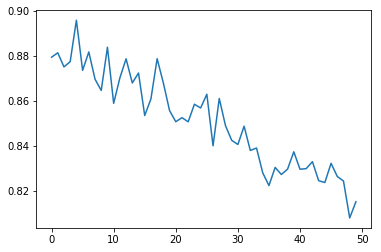

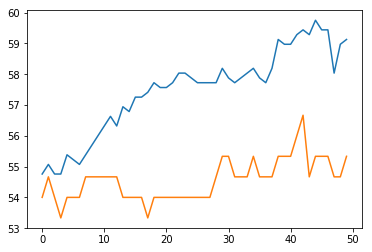

In [45]:
plt.plot(epoch_losses)
plt.show()
plt.plot(np.array(epoch_accuracies).T)
plt.show()

In [46]:
max(epoch_accuracies[0]), max(epoch_accuracies[1])

(59.75039001560062, 56.666666666666664)

## Save model and scaler

In [47]:
torch.save(best_model.state_dict(), "models/yoked_force_model.pt")
joblib.dump(scaler, "scalers/yoked_force_scaler.sk")

['scalers/yoked_force_scaler.sk']

## Evaluate saved model


100%|██████████| 150/150 [00:00<00:00, 309.97it/s]

Model's accuracy on test set: 38.666666666666664


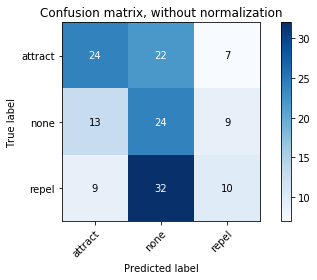

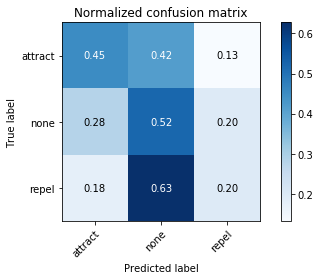

In [48]:
model_path = "models/yoked_force_model.pt"
scaler_path = "scalers/yoked_force_scaler.sk"
network_dims = (INPUT_DIM, HIDDEN_DIM, N_LAYERS, OUTPUT_DIM)
class_columns = FORCE_CLASS_COLS

evaluate_saved_model(model_path, (DROPOUT,), None, training_columns=TR_COLS, arch=DualRNNModel,
                     trials=test_trials, class_columns=class_columns, step_size=STEP_SIZE, scaler_path=scaler_path,
                     categorical_columns=MOUSE_CONTROL_COLS, normalisation_cols=ALT_BASIC_TRAINING_COLS)

# MASS TRAINING (Humans achieve 45% +- 20%)

## Read dataset and preprocess it

scaler = joblib.load("scalers/passive_mass_scaler.sk")

In [ ]:
loaders, scaler = prepare_dataset([train_trials, val_trials, test_trials], training_columns=BASIC_TRAINING_COLS, 
                                  class_columns=MASS_CLASS_COLS, batch_size=BATCH_SIZE, 
                                  normalise_data=NORMALISE_DATA, categorical_columns=MOUSE_CONTROL_COLS)

In [ ]:
train_loader, val_loader, test_loader = loaders

In [ ]:
class_proportions(train_loader)
class_proportions(val_loader)
class_proportions(test_loader)

## Define model, loss and optimizer

## Train model and plot loss and accuracy

In [ ]:
model_path = "models/passive_mass_model.pt"
model = ComplexRNNModel(*network_dims, DROPOUT)
model.load_state_dict(torch.load(model_path))
model.train()
model = model.cuda()
model.rec_layer.requires_grad = True

error = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
epoch_losses, epoch_accuracies, best_model = training_loop(model, optimizer, error, train_loader, val_loader, EPOCHS, 
                                                           step_size=STEP_SIZE)

In [ ]:
plt.plot(epoch_losses)
plt.show()
plt.plot(np.array(epoch_accuracies).T)
plt.show()

In [ ]:
max(epoch_accuracies[1])

## Save model and scaler

In [ ]:
torch.save(best_model.state_dict(), "models/yoked_mass_model.pt")
joblib.dump(scaler, "scalers/yoked_mass_scaler.sk")

## Load model and evaluate

In [ ]:
model_path = "models/yoked_mass_model.pt"
scaler_path = "scalers/yoked_mass_scaler.sk"
network_dims = (INPUT_DIM, HIDDEN_DIM, N_LAYERS, OUTPUT_DIM)
class_columns = MASS_CLASS_COLS

evaluate_saved_model(model_path, network_dims, None, BASIC_TRAINING_COLS,
                     class_columns, step_size=STEP_SIZE, scaler_path=scaler_path, trials=test_trials)